## Feature Extraction Example

In this example we will extract the Histogram of Gradients (HoG), Normalized Difference Vegetation Index (NDVI) and the Pantex features from a test satelite image.

- The HoG feature captures the distribution of structure orientations.
- The NDVI feature captures the level of vegetation.
- The Pantex feature captures the level of built-up structures.

The image will be split into blocks, in this example 20 by 20 pixels, and each feature is calculated for this block using a certain amount of context information called a window. A feature can be calculated on multiple windows to allow for context at different scales.

### In this example
- First we will define the Features we would like to extract and with which window shapes.
- We will then load the image using the `Image` class.
- Then we will split the image into blocks using the `FullGenerator` Class.
- Then we will extract the features using the `extract_features` function.

#### Live iPython Notebook
If you are reading this example on readthedocs.io a notebook of this example is available [in the repository](https://github.com/DynaSlum/satsense/blob/master/notebooks/FeatureExtraction/feature_extraction.ipynb)

In [19]:
# General imports
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline

# Satsense imports
from satsense import Image
from satsense.generators import FullGenerator
from satsense.extract import extract_features
from satsense.features import NirNDVI, HistogramOfGradients, Pantex

### Define the features to calculate

First we define a list of windows for each of the features to use.

Hog and Pantex will be calculated on 2 windows of 25x25 pixels and 23x27 pixels.
NDVI will be calculated on one window with 37x37 pixels.

These window shapes are chose arbitrarily to show the capabilities of satsense, for your own feature extraction you should think and experiment with these window shapes to give you the best results.

N.B. The NDVI feature here is called NirNDVI because that implementation uses the near-infrared band of the image, there are several other implementations of NDVI available in satsense, see [the documentation](https://satsense.readthedocs.io/en/latest/api/satsense.features.html)

In [20]:
# Multiple windows
two_windows = [(25, 25), (23, 37)]
# Single window
one_window = [(37, 37),]
features = [
    HistogramOfGradients(two_windows),
    NirNDVI(one_window),
    Pantex(two_windows),
]

### Load the image

Here we load the image and normalize it to values between 0 and 1. Normalization by default is performed per band using the 2nd and 98th percentiles.

The image class can provide the individual bands, or a number of useful derivatives such as the RGB image or Grayscale, we call these base images. More advanced base images are also available, for instance Canny Edge

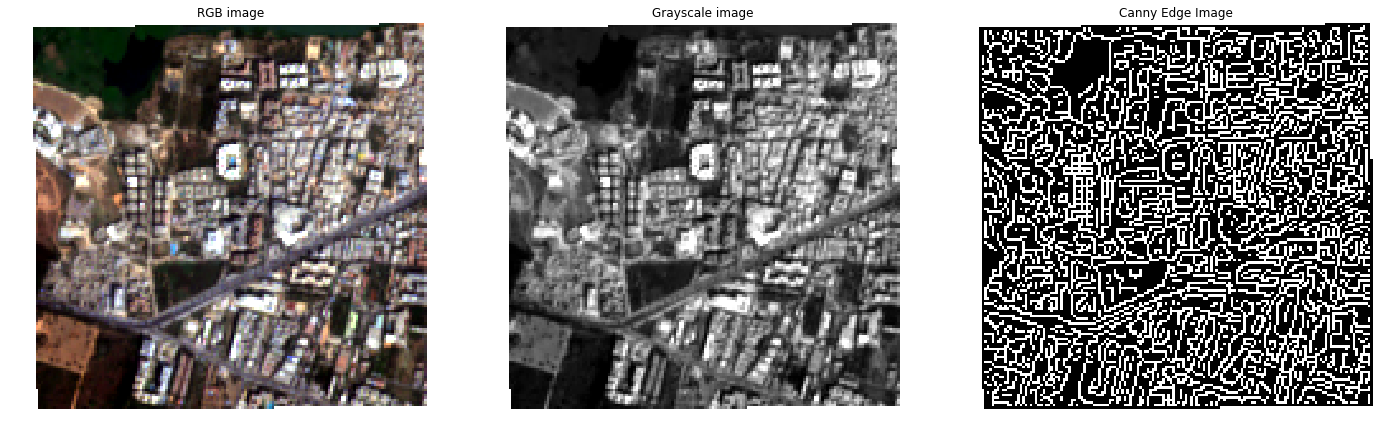

In [21]:
image = Image('../../test/data/source/section_2_sentinel.tif',
                'quickbird')
image.precompute_normalization()

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 8), sharey=True)

ax1.axis('off')
ax1.imshow(image['rgb'])
ax1.set_title('RGB image')

ax2.axis('off')
ax2.imshow(image['grayscale'], cmap="gray")
ax2.set_title('Grayscale image')

ax3.axis('off')
ax3.imshow(image['canny_edge'], cmap="gray")
ax3.set_title('Canny Edge Image')

plt.show()

### Generator

Next we create a generator which splits the image into blocks of 20x20 pixels.

In this cell we also show the images, therefore we load the rgb base image
into the generator. This is only needed here so we can show the blocks using matplotlib
when using the `extract_features` function loading the correct base images will be done
for you based on the features that will be calculated.

The generator is 8 by 8  blocks


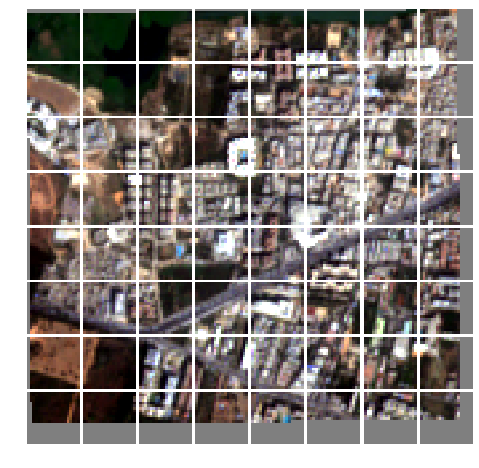

In [22]:
generator = FullGenerator(image, (20, 20))
print("The generator is {} by {}".format(*generator.shape), " blocks")

# Create a gridspec to show the images
gs = gridspec.GridSpec(*generator.shape)
gs.update(wspace=0.05, hspace=0.05)

# Load a baseimage into the generator.
# The window is the same as the block size to show the blocks used
generator.load_image('rgb', ((20, 20),))

fig = plt.figure(figsize=(8, 8))
for i, img in enumerate(generator):
    ax = plt.subplot(gs[i])
    ax.imshow(img.filled(0.5))
    ax.axis('off')

### Calculate all the features and append them to a vector

In this cell we use the `extract_features` function from satsense to extract all features.

`extract_features` returns a generator that we can loop over. Each invocation of the generator returns the
feature vector for one feature in the order of the features list. The shape of this vector is (x, y, w, v)
where
    - x is the number of blocks of the generator in the x direction
    - y is the number of blocks of the generator in the y direction
    - w is the number of windows the feature is calculated on
    - v is the length of the feature per window

We use a little numpy reshaping to merge these feature vectors into a single feature vector of shape (x, y, n)
where n is the total length of all features over all windows.
In this example it will be (8, 8, 13) because:
    - HoG has 5 numbers per window and 2 windows  :   10
    - NirNDVI has 1 number per window and 1 window:    1
    - Pantex has 1 number per window and 2 windows:    2
                                             Total:   13

In [23]:
vector = []
for feature_vector in extract_features(features, generator):
    # The shape returned is (x, y, w, v)
    # Reshape the resulting vector so it is (x, y, w * v)
    # e.g. flattened along the windows and features
    data = feature_vector.vector.reshape(
                *feature_vector.vector.shape[0:2], -1)
    vector.append(data)
# dstack reshapes the vector into and (x, y, n)
# where n is the total length of all features
featureset = np.dstack(vector)

print("Feature set has shape:", featureset.shape)

Feature set has shape: (8, 8, 13)


### Showing the resulting features

Below we show the results for the calculated features.

In the result images you can see the edges of the feature vector have been masked as the windows at the edge of the original image contain masked values. Furthermore, please keep in mind that the value for the feature in each block depends on an area around the block.

#### HoG
Here is the result of the HoG feature, we display the first value for each window.

Histogram of Gradients is a feature that first calculates a histogram of the gradient orientations in the window. Using this histogram 5 values are calculated.
This first value is the 1st heaved central shift moment. Heaved central shift moments are a measure of spikiness of a histogram.

The other values are: the 2nd heaved central shift moment, the orientation of the highest and second highest peaks and the sine of the absolute difference between the highest and second highest peak (this is 1 for right angles).

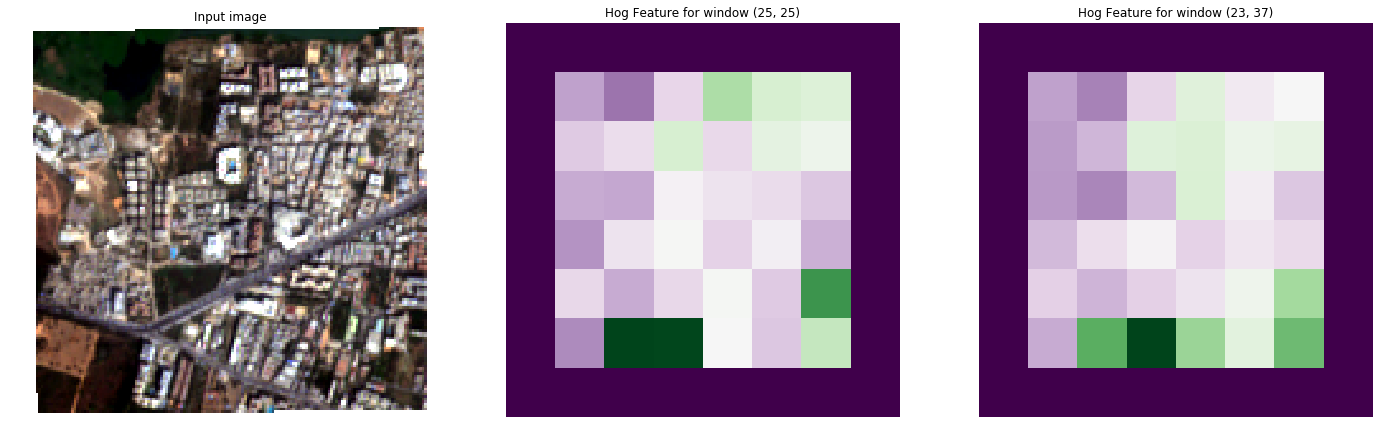

In [24]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 8))

ax1.axis('off')
ax1.imshow(image['rgb'])
ax1.set_title('Input image')

ax2.axis('off')
ax2.imshow(featureset[:, :, 0], cmap="PRGn")
ax2.set_title('Hog Feature for window {}'.format(two_windows[0]))

ax3.axis('off')
ax3.imshow(featureset[:, :, 5], cmap="PRGn")
ax3.set_title('Hog Feature for window {}'.format(two_windows[1]))

plt.show()

#### NDVI

Here we show the result for the NDVI feature

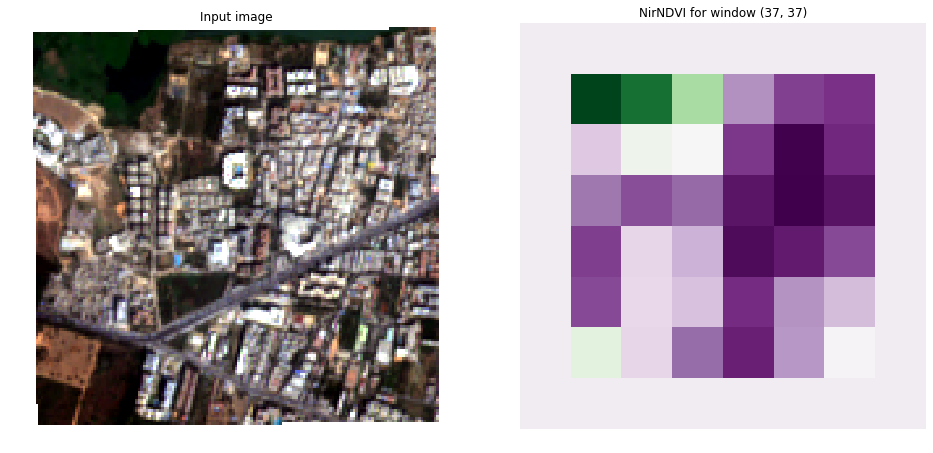

In [25]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

ax1.axis('off')
ax1.imshow(image['rgb'])
ax1.set_title('Input image')

ax2.axis('off')
ax2.imshow(featureset[:, :, 10], cmap="PRGn")
ax2.set_title('NirNDVI for window {}'.format(one_window[0]))

plt.show()

#### Texton

Here we show the results for the Texton feature.

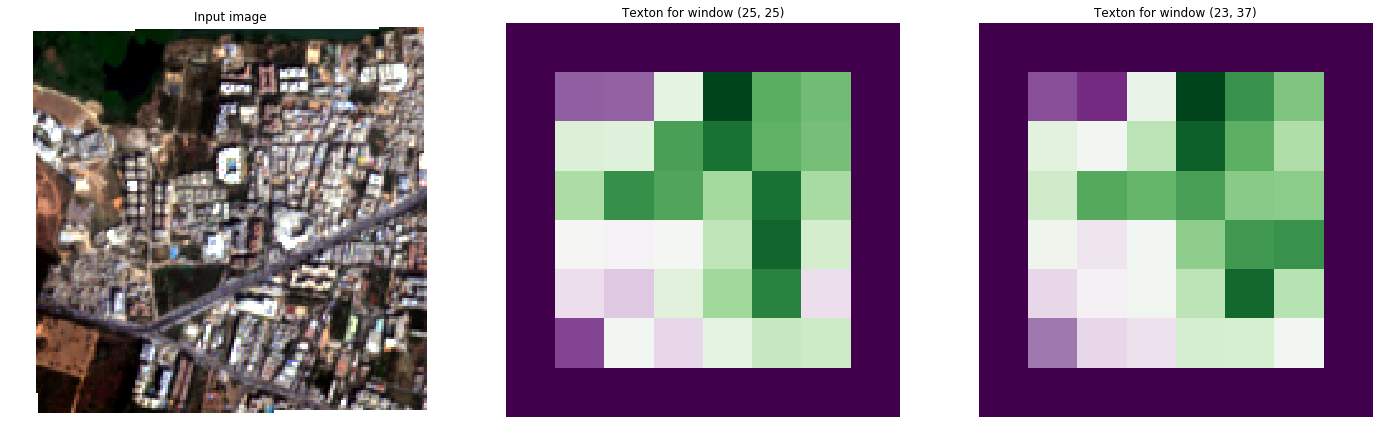

In [26]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 8))

ax1.axis('off')
ax1.imshow(image['rgb'])
ax1.set_title('Input image')

ax2.axis('off')
ax2.imshow(featureset[:, :, 11], cmap="PRGn")
ax2.set_title('Texton for window {}'.format(two_windows[0]))

ax3.axis('off')
ax3.imshow(featureset[:, :, 12], cmap="PRGn")
ax3.set_title('Texton for window {}'.format(two_windows[1]))

plt.show()